# Characterizing Bias and Variance: A set of tests for model selection and evaluation
--------
### Julien Brenneck, July 2018

In [1]:
import numpy as np
import pandas as pd
import time, datetime

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import seaborn
seaborn.set_color_codes()

cm = mpl.cm.RdBu
cm = mpl.cm.viridis
cm_g = mpl.cm.Greens_r
h = 0.02

## Making a dataset
The $X$ variable is a $d$ dimensional multivariate normal centered at zero (no covariance).

The $y$ variable is $X$ projected onto a sine wave, with gaussian noise added.

$$
y_j = \prod_{i=1}^{d} \sin(X_{ij}) + \epsilon
$$

A non linear regression with noise was chosen to avoid having too simple of a model. A simple model needs very few data points to be fit, and strange effects can occur on very small data sets.

In [2]:
def gen_data(n=100, noise=0.1, dim=1, scale=1):
    X = np.random.normal(loc=0, scale=scale, size=(n, dim))
    y = np.sin(X).prod(axis=1) + np.random.normal(scale=noise, size=(n))
    return X, y

In one dimension

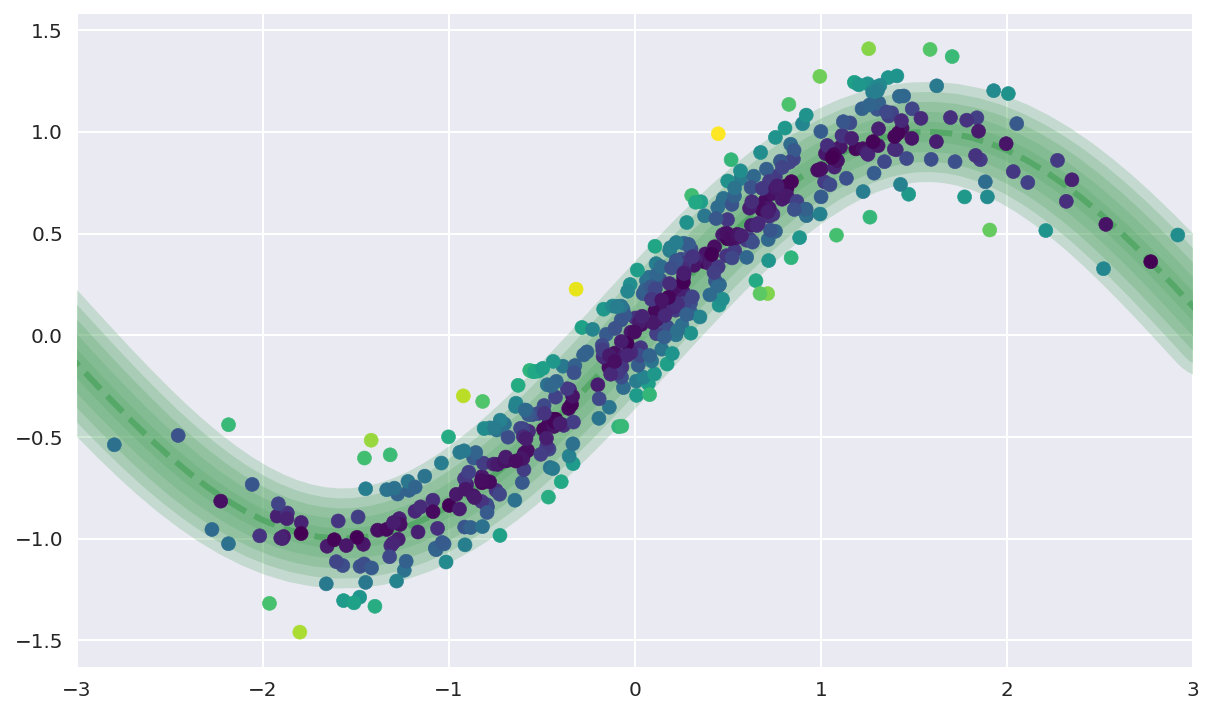

In [3]:
X, y = gen_data(n=500, noise=0.2)
plt.figure(figsize=(10,6))
plt.xlim(-3,3)
grid_x = np.arange(-3.5,3.5,0.1)
grid_y = np.sin(grid_x)
err_y = np.abs(y - np.sin(X).flatten())
for i in range(50, 1, -10):
    plt.plot(grid_x, grid_y, 'g', lw=i, alpha=0.25)
plt.plot(grid_x, grid_y, '--g', lw=3, alpha=1.0)
plt.scatter(X, y, c=err_y, cmap=cm, zorder=100)

In two dimensions

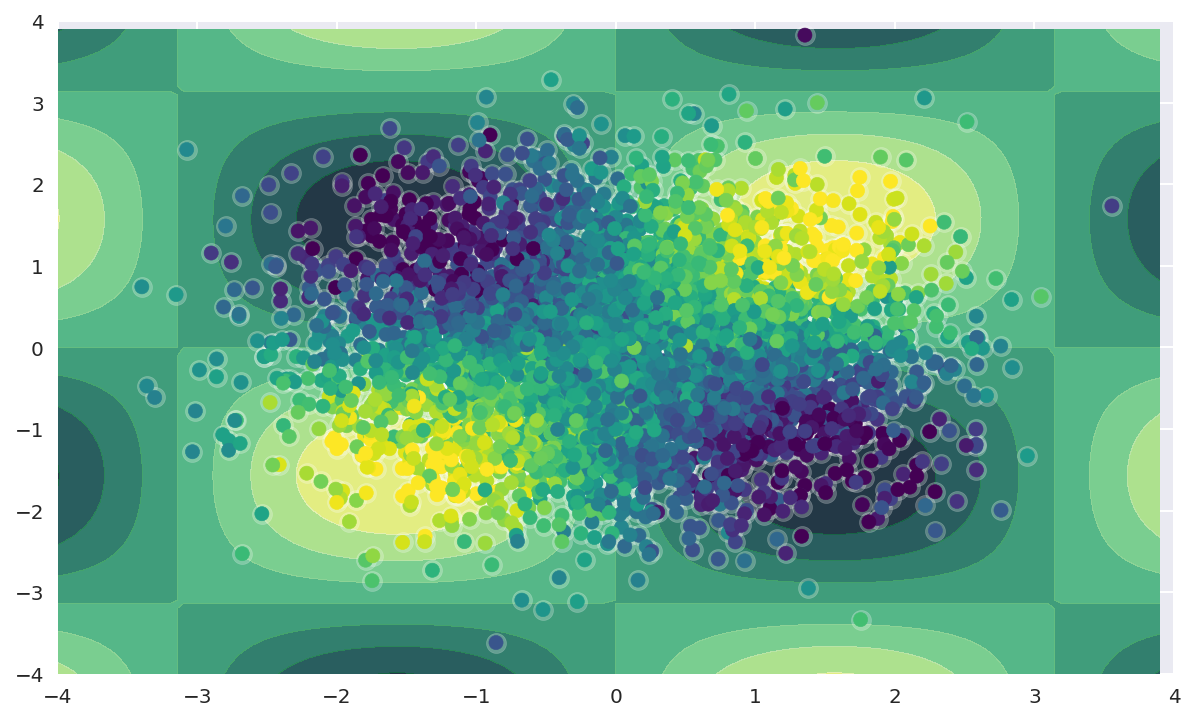

In [4]:
X, y = gen_data(n=5000, noise=0.2, dim=2)
plt.figure(figsize=(10,6))
grid_x, grid_y = np.meshgrid(np.arange(-4,4,0.1), np.arange(-4,4,0.1))
grid_z = np.sin(grid_x) * np.sin(grid_y)
vmin, vmax = np.min(grid_z), np.max(grid_z)
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.contourf(grid_x, grid_y, grid_z, alpha=1.0, vmin=-1, vmax=1, cmap=cm)
plt.contourf(grid_x, grid_y, grid_z, alpha=0.5, vmin=-1, vmax=1, cmap=cm_g)
plt.scatter(X[:,0], X[:,1], color='w', alpha=0.25, vmin=-1, vmax=1, s=100)
plt.scatter(X[:,0], X[:,1], c=y, cmap=cm, alpha=1.0, vmin=-1, vmax=1, s=50)

In [7]:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
# gives progress bar for loops, fall back to default range
try:
    from tqdm import tnrange, tqdm_notebook, trange
except ImportError:
    def tnrange(n, desc=''):
        return range(n)
    trange=range

## Taking sample variance of CV scores
This does not let us accurately quantify the amount of variance in the CV estimate (it is a heavily biased estimator) but it lets us see the general trend of bias-variance tradeoff as $K$ is varied. 
For small $K$ there is little variance but a large pessimistic bias, and for large $K$ there is a large variance.
It is clear in this plot why $K=10$ might be a reasonable compromise. 

In [10]:
N = 500
X, y = gen_data(n=N, noise=0.5, dim=2)
test_x, test_y = gen_data(n=100000, noise=0.5, dim=2)
model = SVR(C=10e-3)
scores = np.zeros(N-1)
std = np.zeros(N-1)
# for i in range(N-1):
for i in range(N-1):
    z = cross_val_score(model, X, y, cv=KFold(i+2), n_jobs=-1, scoring='neg_mean_squared_error')
    scores[i] = np.mean(z)
    std[i] = np.std(z)
model.fit(X, y)
mae = mean_squared_error(model.predict(test_x), test_y)
opt = mean_squared_error(np.sin(test_x).prod(axis=1), test_y)

In [7]:
t = pd.Timestamp.now()
date = t.isoformat().split('.')[0]
data = pd.DataFrame({'scores': scores, 'std': std, 'mae': mae, 'opt': opt})
# data.to_csv('data/kfold-cv-' + date + '.csv')

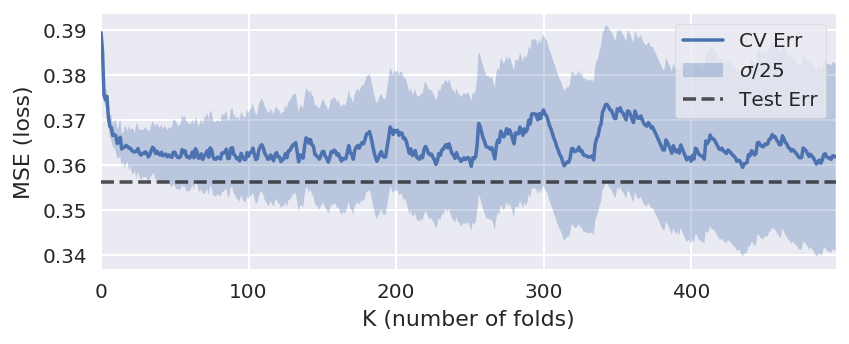

In [23]:
N = 500
scores = np.abs(scores)
plt.figure(figsize=(6,2.5))
plt.plot(np.arange(N-1), scores, label="CV Err")
plt.fill_between(np.arange(N-1), scores-std/25, scores+std/25, alpha=0.3, label="$\sigma/25$")
plt.hlines(mae, 0, N, linestyles='--', color='k', alpha=0.75, label="Test Err")
# plt.hlines(opt, 0, N, linestyles='--', color='g', alpha=0.75, label="Optimal")
plt.xlim(0,N-2)
# plt.title("Choice of K in K-Fold CV")
plt.xlabel("K (number of folds)")
plt.ylabel("MSE (loss)")
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
# plt.savefig('plots/kfold-cv-std-6x3.pdf')

In [70]:
N = 1000
X, y = gen_data(n=N, noise=0.0, dim=2)
test_x, test_y = gen_data(n=100000, noise=0.0, dim=2)
model = SVR(C=10e-3)
scores = np.zeros(N-1)
std = np.zeros(N-1)
# for i in range(N-1):
for i in range(N-1):
    cv = KFold(i+2)
    s = np.zeros(X.shape[0])
    for train_index, test_index in cv.split(X):
        model.fit(X[train_index], y[train_index])
        s[test_index] = np.abs(model.predict(X[test_index]) - y[test_index])
    scores[i] = np.mean(s)
    std[i] = np.std(s)
model.fit(X, y)
mae = mean_squared_error(model.predict(test_x), test_y)
opt = mean_squared_error(np.sin(test_x).prod(axis=1), test_y)

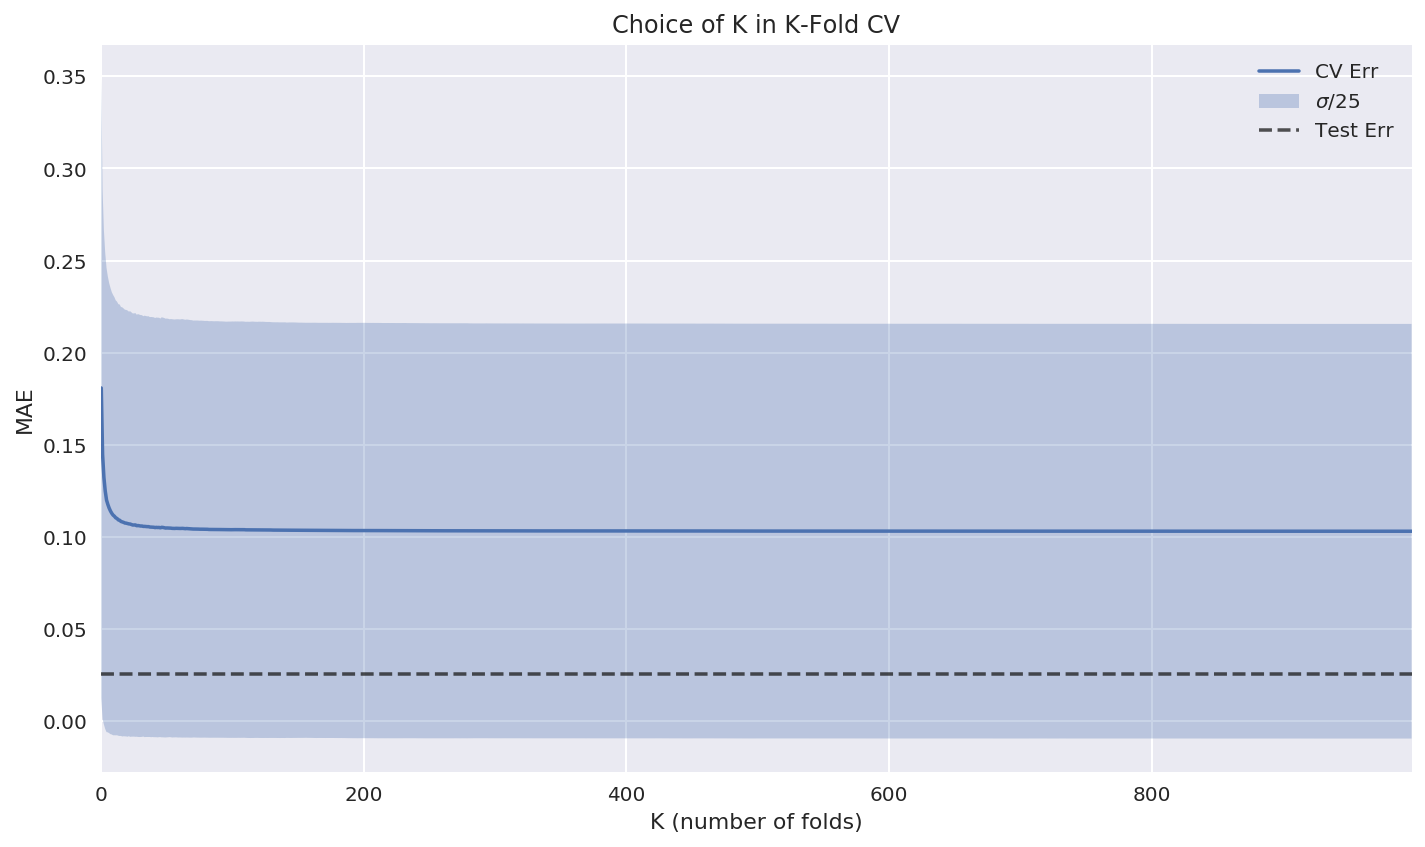

In [71]:
N = 1000
scores = np.abs(scores)
plt.figure(figsize=(10,6))
plt.plot(np.arange(N-1), scores, label="CV Err")
plt.fill_between(np.arange(N-1), scores-std, scores+std, alpha=0.3, label="$\sigma/25$")
plt.hlines(mae, 0, N, linestyles='--', color='k', alpha=0.75, label="Test Err")
# plt.hlines(opt, 0, N, linestyles='--', color='g', alpha=0.75, label="Optimal")
plt.xlim(0,N-2)
plt.title("Choice of K in K-Fold CV")
plt.xlabel("K (number of folds)")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
# plt.savefig('plots/kfold-cv-std-5x4.pdf')

# Variance of CV over datasets
Instead of measuring variance between folds, another approach is to measure the variance of CV estimates from different datasets drawn from the same distribution.
We can do this since our dataset is synthetic, as many samples can be taken as needed.
This also lets us estimate a "true" test error, by using a very large number of samples as a test set. This is essentially monte carlo integration, giving an accurate estimation of true generalization error.

This experiment is essentially the previous experiment run many times, so it is computationally expensive and can take hours.

In [7]:
N = 500
M = 10
scores_all = np.zeros((M, N-1))
std_all = np.zeros((M, N-1))
model = SVR(C=10e-3)
mae_all = np.zeros(M)
test_x, test_y = gen_data(n=100000, noise=0.0, dim=4)
start_time = time.time()
for j in trange(M):
    time_1 = time.time()
    X, y = gen_data(n=N, noise=0.0, dim=4)
    for i in range(N-1):
        z = cross_val_score(model, X, y, cv=KFold(i+2), n_jobs=-1, scoring='neg_mean_squared_error')
        scores_all[j, i] = np.mean(z)
        std_all[j, i] = np.std(z)
    model.fit(X, y)
    mae_all[j] = mean_squared_error(model.predict(test_x), test_y)
#     print("iter: ", j, "time: ", str(int(time.time()-time_1)))
opt_all = mean_squared_error(np.sin(test_x).prod(axis=1), test_y)
# print("total time:", time.time() - start_time)

100%|██████████| 10/10 [1:05:22<00:00, 392.22s/it]


In [8]:
t = pd.Timestamp.now()
s1 = np.abs(np.mean(scores_all, axis=0))
s2 = np.std(np.abs(scores_all), axis=0)
date = t.isoformat().split('.')[0]
data = pd.DataFrame({'scores': s1, 'std': s2, 'mae': np.mean(mae_all), 'opt': opt_all})
data.to_csv('data/kfold-alt-' + date + '.csv')

Simply taking the sample mean and variance at each $K$ gives a strange result.
The bias is as expected, but the variance is constant.
This is due to the large bias inherent to each training set.
If we plot the CV estimate curves individually (shown below) we see that the variance due to this bias is causing the effect.
If the bias is removed from the results (centering them using the low bias/variance region between $K=(25,75)$) we get the expected growth in variance as $K$ is increased. 
Note that one standard deviation here is an order of magnitude smaller than in the previous test, so clearly the exact numbers from CV fold variance (the only method usable in practice) are too heavily biased to give meaningful estimates. Example: fold std of 0.33 at $K=400$, dataset var of 0.004 at $K=400$.

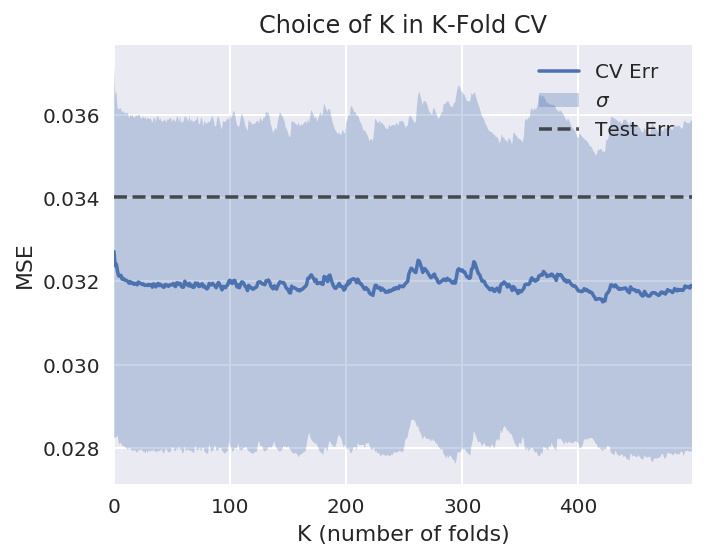

In [17]:
N = 500
s1 = np.abs(np.mean(scores_all, axis=0))
s2 = np.std(np.abs(scores_all), axis=0)
plt.figure(figsize=(5,4))
plt.plot(s1, label="CV Err")
plt.fill_between(np.arange(N-1), s1-s2, s1+s2, alpha=0.3, label="$\sigma$")
plt.hlines(np.mean(mae_all), 0, N, linestyles='--', color='k', alpha=0.75, label="Test Err")
# plt.hlines(opt_all, 0, N, linestyles='--', color='g', alpha=0.75, label="Optimal")
plt.xlim(0,N-2)
plt.title("Choice of K in K-Fold CV")
plt.xlabel("K (number of folds)")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
# plt.savefig('plots/kfold-alt-5x4.pdf')

Plot each curve to show dataset bias.

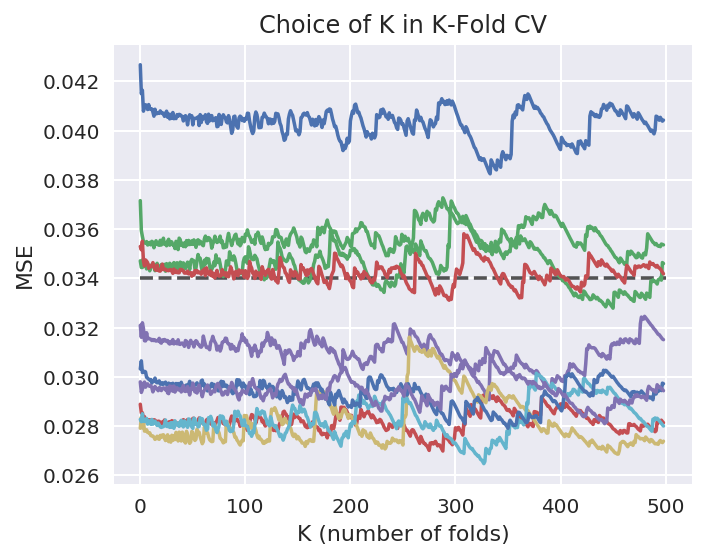

In [20]:
plt.figure(figsize=(5,4))
for i in range(M):
    plt.plot(np.arange(N-1), np.abs(scores_all[i,:]))
plt.hlines(np.mean(mae_all), 0, N, linestyles='--', color='k', alpha=0.75, label="Test Err")
plt.xlabel("K (number of folds)")
plt.ylabel("MSE")
plt.title("Choice of K in K-Fold CV")
plt.tight_layout()
# plt.savefig('plots/kfold-alt-all-5x4.pdf')

Attempting to remove bias (this is not great statistically but it works to show bias/variance tradeoff).

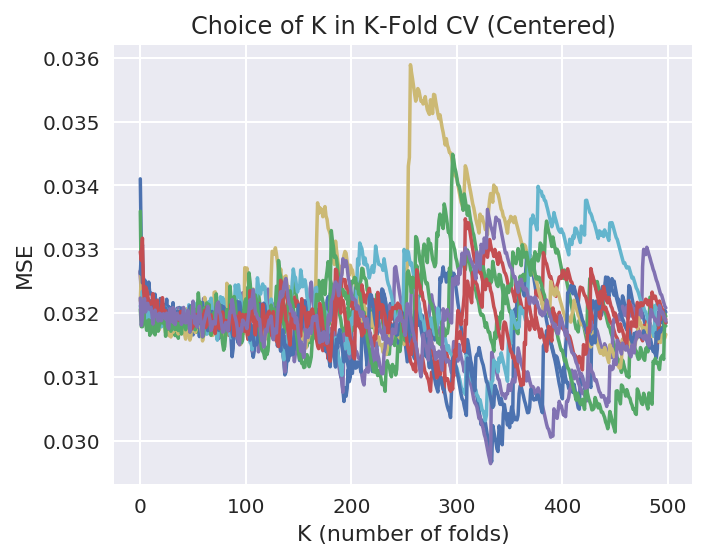

In [25]:
plt.figure(figsize=(5,4))
temp = np.abs(scores_all) + np.mean(scores_all[:,10:110], axis=1).reshape(-1,1) - np.mean(scores_all) 
for i in range(M):
    plt.plot(np.arange(N-1), temp[i,:])
plt.xlabel("K (number of folds)")
plt.ylabel("MSE")
plt.title("Choice of K in K-Fold CV (Centered)")
plt.tight_layout()
# plt.savefig('plots/kfold-alt-center-5x4.pdf')

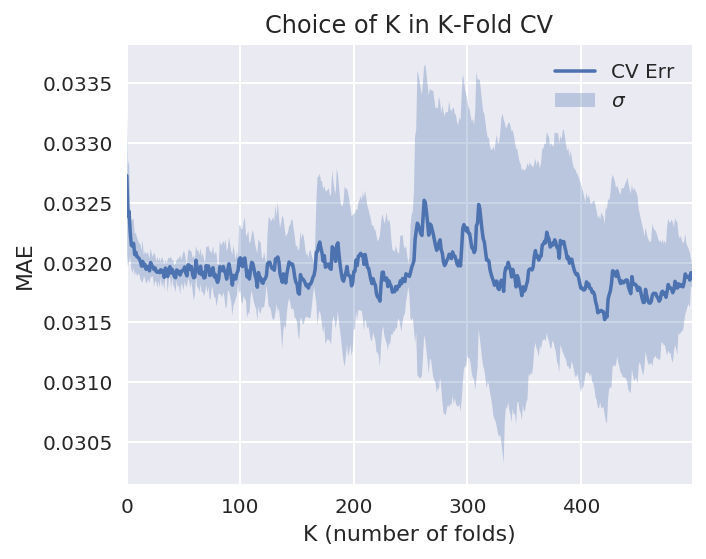

In [26]:
N = 500
recentered = np.abs(scores_all) + np.mean(scores_all[:,25:75], axis=1).reshape(-1,1) - np.mean(scores_all)
s1 = np.mean(recentered, axis=0)
s2 = np.std(recentered, axis=0)
plt.figure(figsize=(5,4))
plt.plot(s1, label="CV Err")
plt.fill_between(np.arange(N-1), s1-s2, s1+s2, alpha=0.3, label="$\sigma$")
# plt.hlines(np.mean(mae_all), 0, N, linestyles='--', color='k', alpha=0.75, label="Test Err")
# plt.hlines(opt_all, 0, N, linestyles='--', color='g', alpha=0.75, label="Optimal")
plt.xlim(0,N-2)
plt.title("Choice of K in K-Fold CV")
plt.xlabel("K (number of folds)")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
# plt.savefig('plots/kfold-alt-5x4.pdf')

## Variance in model selection
This one isn't showing the effect very well, might try again with different model/data or with classification problem. Attempting to recreate the "hypothetical" example in (Cawley and Talbot 2010), see page 2087 for details.

.........................

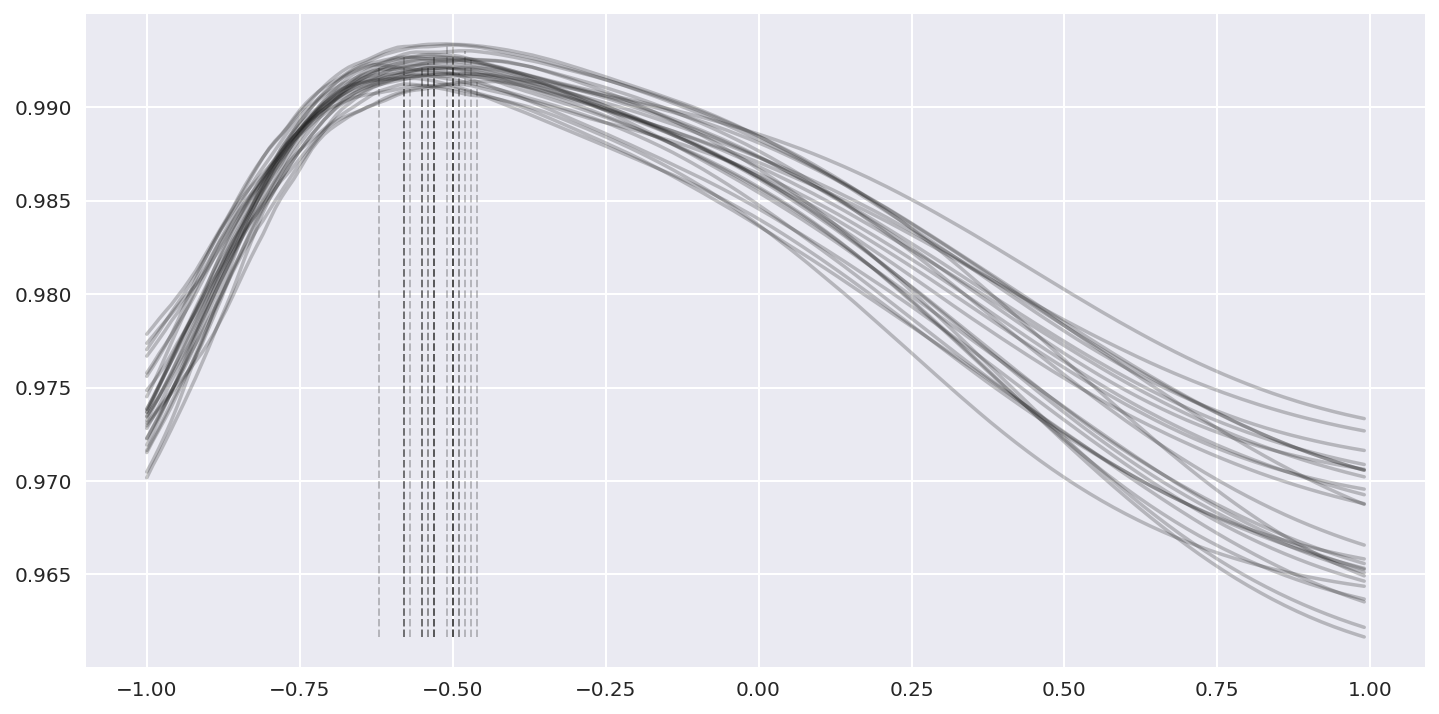

In [6]:
N = 500
trials = 25
theta = np.arange(-1, 1, 0.01)
model_scores = np.zeros((trials, theta.size))
for j in range(trials):
    X, y = gen_data(n=N, noise=0.0, dim=4)
    for i in range(theta.size):
        rbf = SVR(gamma=10**theta[i], kernel='rbf')
        z = cross_val_score(rbf, X, y, n_jobs=-1, cv=KFold(10), scoring='neg_mean_squared_error')
        model_scores[j, i] = np.mean(z)
    print('.', end='')

plt.figure(figsize=(12,6))
for j in range(trials):
    plt.plot(theta, 1+model_scores[j,:], alpha=0.25, color='k')
    m = np.argmax(model_scores[j,:])
    plt.vlines(theta[m], linestyles='--', ymax=1+model_scores[j,m], ymin=np.min(model_scores)+1, lw=1, alpha=0.25)

In [7]:
np.std(theta[np.argmax(model_scores, axis=1)])

0.038731898998112683

.........................

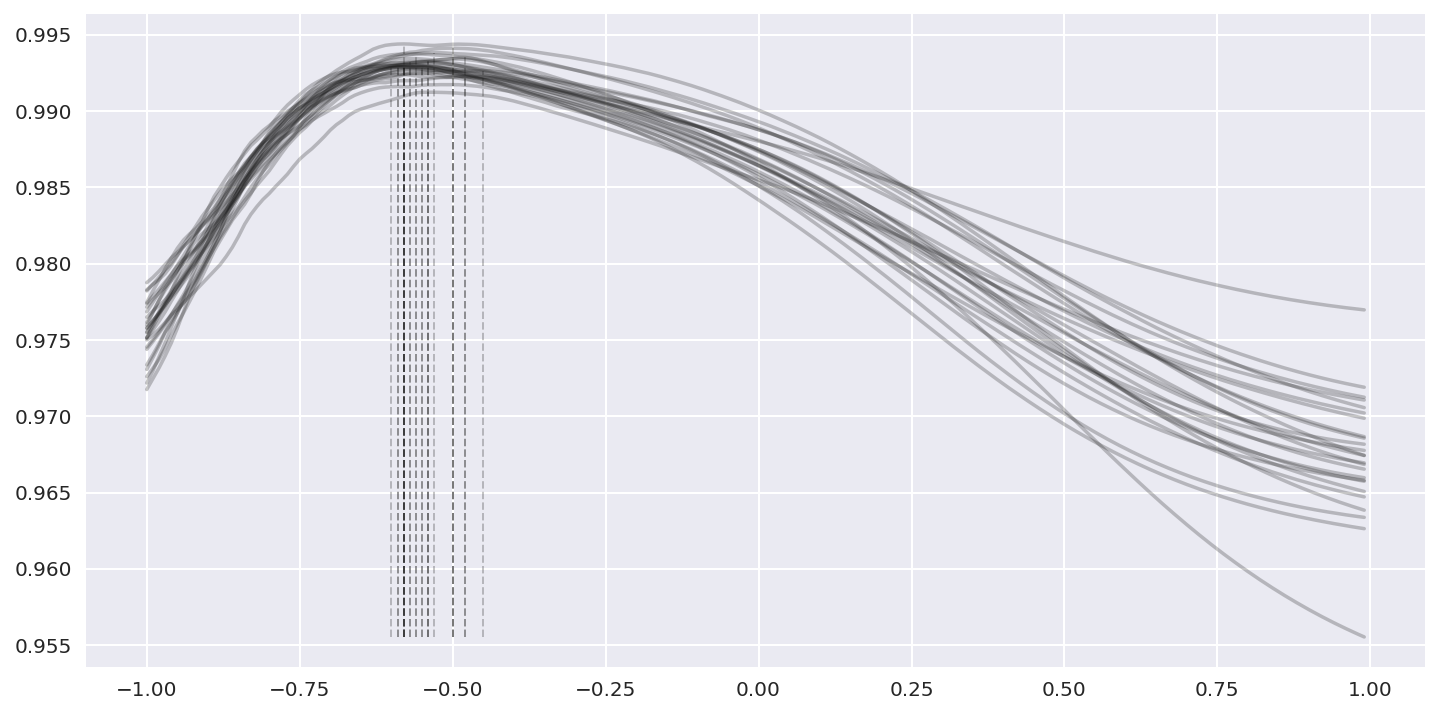

In [8]:
N = 500
trials = 25
theta = np.arange(-1, 1, 0.01)
model_scores_loo = np.zeros((trials, theta.size))
for j in range(trials):
    X, y = gen_data(n=N, noise=0.0, dim=4)
    for i in range(theta.size):
        rbf = SVR(gamma=10**theta[i], kernel='rbf')
        z = cross_val_score(rbf, X, y, n_jobs=-1, cv=LeaveOneOut(), scoring='neg_mean_squared_error')
        model_scores_loo[j, i] = np.mean(z)
    print('.', end='')

plt.figure(figsize=(12,6))
for j in range(trials):
    plt.plot(theta, 1+model_scores_loo[j,:], alpha=0.25, color='k')
    m = np.argmax(model_scores_loo[j,:])
    plt.vlines(theta[m], linestyles='--', ymax=1+model_scores_loo[j,m], ymin=np.min(model_scores_loo)+1, lw=1, alpha=0.25)

In [9]:
np.std(theta[np.argmax(model_scores_loo, axis=1)])

0.03995197116538811